In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

### get daily data and immediately convert it to monthly

In [4]:
year = '1964'
path = '/glade/scratch/mlevy/feisty_output/full_companion_run.001/hist/companion.' + year + '.zarr'

In [5]:
ds = xr.open_zarr(path, consolidated=False)

In [6]:
ds

<xarray.Dataset>
Dimensions:  (group: 9, nlat: 384, nlon: 320, time: 365)
Coordinates:
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 1964-01-01 00:00:00 ... 1964-12-31 00:00:00
Data variables:
    biomass  (time, group, nlat, nlon) float64 dask.array<chunksize=(365, 9, 128, 80), meta=np.ndarray>

In [7]:
ds_mon = ds.resample({'time':'M'}).mean(dim='time').compute()

In [8]:
ds_mon.biomass

<xarray.DataArray 'biomass' (time: 12, group: 9, nlat: 384, nlon: 320)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [7.02820390e-05, 7.02480318e-05, 7.05988129e-05, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [8.53233950e-06, 8.53051358e-06, 8.52316647e-06, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [1.88198027e-01, 1.96416886e-01, 2.13611145e-01, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * time     (time) object 1964-01-31 00:00:00 ... 1964-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

In [10]:
file = '/glade/scratch/mlevy/feisty_output/full_companion_run.001/hist/companion.monthly.1958-2021.nc'
ds = xr.open_dataset(file)

In [11]:
ds.biomass

<xarray.DataArray 'biomass' (time: 768, group: 9, nlat: 384, nlon: 320)>
[849346560 values with dtype=float64]
Coordinates:
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 1958-01-31 00:00:00 ... 2021-12-31 00:00:00

In [12]:
# ### first do 1958
# year=1958

# yr4="{:04d}".format(year)
# path = '/glade/scratch/mlevy/feisty_output/hist/companion.' + yr4 + '.zarr'

# ds_tmp = xr.open_zarr(path, consolidated=False)

# ds = ds_tmp.resample({'time':'M'}).mean(dim='time').compute()

# ### then do the rest of the years

# for year in np.arange(1959,2022,1):
#     print(year)
#     yr4="{:04d}".format(year)
#     path = '/glade/scratch/mlevy/feisty_output/hist/companion.' + yr4 + '.zarr'
    
#     ds_tmp = xr.open_zarr(path, consolidated=False)
    
#     ds_mon = ds_tmp.resample({'time':'M'}).mean(dim='time').compute()
    
#     ds = xr.concat([ds, ds_mon], "time")

In [13]:
#/glade/scratch/mlevy/feisty_output/hist/companion.monthly.1958-2021.nc

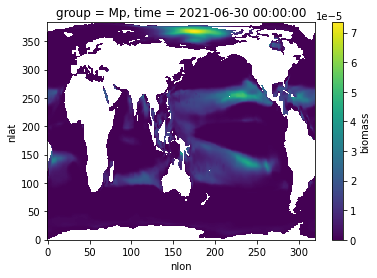

In [14]:
ds.biomass.sel(group='Mp').isel(time=761).plot()

### spin up some dask to make the processing faster

In [15]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [16]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [17]:
client

Client Scheduler: tcp://10.12.206.56:43647 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
### annual mean

ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [19]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

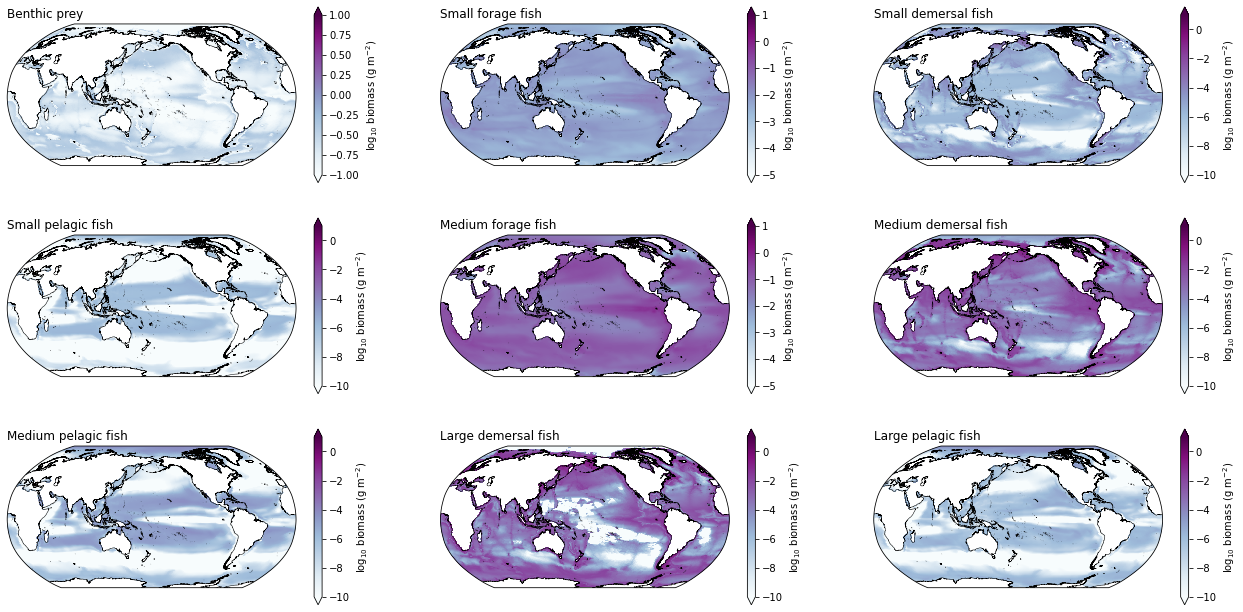

In [20]:
fig = plt.figure(figsize=(22,11))


########################################################################### Benthic prey
ax = fig.add_subplot(3,3,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Benthic prey', loc='left')
group ='benthic_prey'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63))) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-1, vmax=1, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

########################################################################### small forage
ax = fig.add_subplot(3,3,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Small forage fish', loc='left')
group='Sf'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63))) 

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

########################################################################### small demersal
ax = fig.add_subplot(3,3,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Small demersal fish', loc='left')
group ='Sd'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63))) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')


########################################################################### small pelagic
ax = fig.add_subplot(3,3,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Small pelagic fish', loc='left')
group = 'Sp'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63))) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')


########################################################################### medium forage
ax = fig.add_subplot(3,3,5, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Medium forage fish', loc='left')
group = 'Mf'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63))) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')


########################################################################### med demersal
ax = fig.add_subplot(3,3,6, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Medium demersal fish', loc='left')
group ='Md'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63)))

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')


########################################################################### med pelagic
ax = fig.add_subplot(3,3,7, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Medium pelagic fish', loc='left')
group = 'Mp'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63)))

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

########################################################################### large demersal
ax = fig.add_subplot(3,3,8, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Large demersal fish', loc='left')
group = 'Ld'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63)))

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

########################################################################### large pelagic
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Large pelagic fish', loc='left')
group ='Lp'
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(ds_ann.biomass.sel(group=group).isel(time=63)))

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-10,vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

### Sum up forage fish, pelagics, and demersals, and all fish

In [21]:
tot_forage = ds_ann.biomass.sel(group='Sf').isel(time=63) + ds_ann.biomass.sel(group='Mf').isel(time=63)

tot_pelagic = ds_ann.biomass.sel(group='Sp').isel(time=63) + ds_ann.biomass.sel(group='Mp').isel(time=63) + ds_ann.biomass.sel(group='Lp').isel(time=63)
                                                                                                 
                                                                                                 

tot_demersal = ds_ann.biomass.sel(group='Sd').isel(time=63) + ds_ann.biomass.sel(group='Md').isel(time=63) + ds_ann.biomass.sel(group='Ld').isel(time=63)

tot_fish = tot_forage + tot_pelagic + tot_demersal

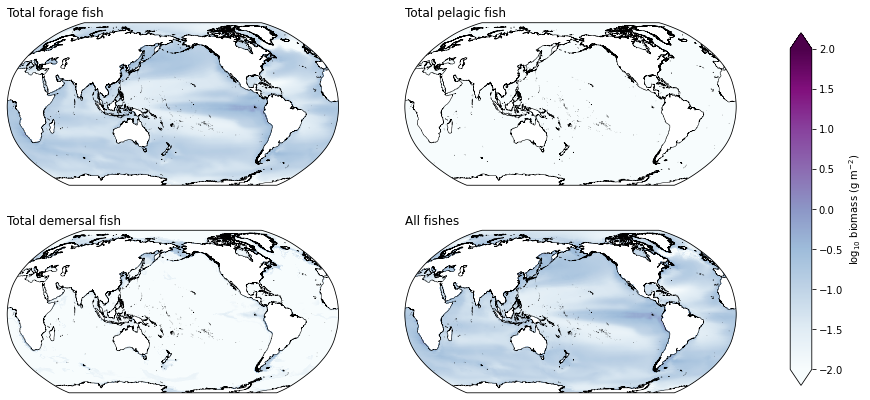

In [22]:
fig = plt.figure(figsize=(15,7))


########################################################################### 
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total forage fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_forage)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-2, vmax=2, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

########################################################################### 
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_pelagic)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-2, vmax=2, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())
########################################################################### 
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_demersal)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-2, vmax=2, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())
########################################################################### 
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('All fishes', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-2, vmax=2, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

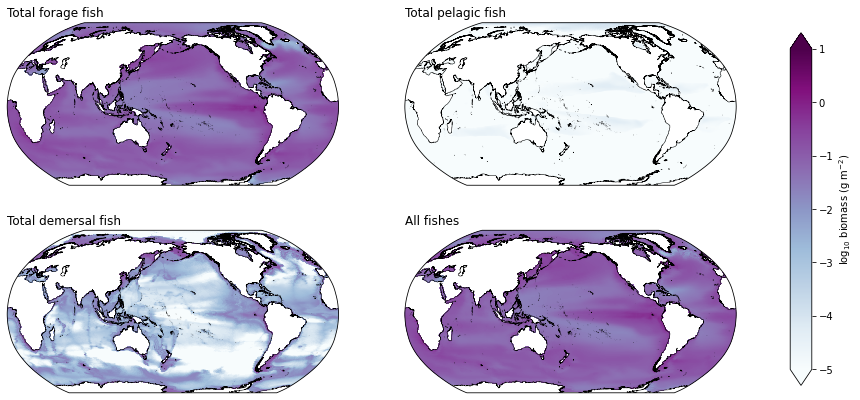

In [23]:
fig = plt.figure(figsize=(15,7))


########################################################################### 
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total forage fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_forage)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5, vmax=1, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

########################################################################### 
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_pelagic)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5, vmax=1,
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())
########################################################################### 
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('Total demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_demersal)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5, vmax=1, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())
########################################################################### 
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('All fishes', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish)) 
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-5, vmax=1, 
                 cmap='BuPu',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='log$_{10}$ biomass (g m$^{-2}$)')

### Rgional averages

In [24]:
###box 1, North Pacific
box1_latmin = 35
box1_latmax = 50
box1_lonmin = -170.
box1_lonmax = -140.


###box 2, subtropical North Pacific
box2_latmin = 15
box2_latmax = 25
box2_lonmin = -170.
box2_lonmax = -140.

###box 3, subantarcic  Pacific sector
box3_latmin = -55
box3_latmax = -45
box3_lonmin = -170.
box3_lonmax = -140.

###box 4, North Atlantic
box4_latmin = 40
box4_latmax = 50
box4_lonmin = -45.
box4_lonmax = -10.

###box 5, Eastern equatorial pacific
box5_latmin = -5
box5_latmax = 5
box5_lonmin = -105.
box5_lonmax = -80.

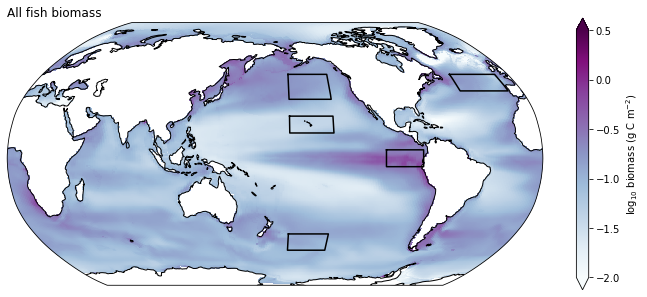

In [25]:
group = 'Mp'

fig = plt.figure(figsize=(12,5))

##################################################################### modis chlorophyll
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('All fish biomass', loc = 'left')
#ax.set_extent([-180, 180, -90, 90], ccrs.Robinson(central_longitude=180))

ax.coastlines('110m',linewidth=1)

lon, lat, field = utils.adjust_pop_grid(lons, lats,  np.log10(tot_fish))

pc=ax.pcolormesh(lon, lat, field, cmap='BuPu',
                 vmin=-2,vmax=0.5,
                 #norm=colors.LogNorm(vmin=0.001, vmax=1),
                          transform=ccrs.PlateCarree())

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

fig.colorbar(pc,extend='both', label='log$_{10}$ biomass (g C m$^{-2}$)');

In [26]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [27]:
lons_norm = utils.normal_lons(lons)

In [28]:
variables = ds.group.values

In [29]:
ts_box1 = xr.Dataset()
ts_box2 = xr.Dataset()
ts_box3 = xr.Dataset()
ts_box4 = xr.Dataset()
ts_box5 = xr.Dataset()

for var in variables:
    print(var)
    
    mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    masked = ds.biomass.sel(group=var).where(mask==1)
    masked_area = area.where(mask==1)
    ## reset nlon and nlat; otherwise there's an error
    mask['nlat'] = ds_grid.nlat
    masked['nlat'] = ds_grid.nlat
    masked_area['nlat'] = ds_grid.nlat
    mask['nlon'] = ds_grid.nlon
    masked['nlon'] = ds_grid.nlon
    masked_area['nlon'] = ds_grid.nlon
    ts_box1[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    mask = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    masked = ds.biomass.sel(group=var).where(mask==1)
    masked_area = area.where(mask==1)
    ## reset nlon and nlat; otherwise there's an error
    mask['nlat'] = ds_grid.nlat
    masked['nlat'] = ds_grid.nlat
    masked_area['nlat'] = ds_grid.nlat
    mask['nlon'] = ds_grid.nlon
    masked['nlon'] = ds_grid.nlon
    masked_area['nlon'] = ds_grid.nlon
    ts_box2[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    mask = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
    masked = ds.biomass.sel(group=var).where(mask==1)
    masked_area = area.where(mask==1)
    ## reset nlon and nlat; otherwise there's an error
    mask['nlat'] = ds_grid.nlat
    masked['nlat'] = ds_grid.nlat
    masked_area['nlat'] = ds_grid.nlat
    mask['nlon'] = ds_grid.nlon
    masked['nlon'] = ds_grid.nlon
    masked_area['nlon'] = ds_grid.nlon
    ts_box3[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    mask = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
    masked = ds.biomass.sel(group=var).where(mask==1)
    masked_area = area.where(mask==1)
    ## reset nlon and nlat; otherwise there's an error
    mask['nlat'] = ds_grid.nlat
    masked['nlat'] = ds_grid.nlat
    masked_area['nlat'] = ds_grid.nlat
    mask['nlon'] = ds_grid.nlon
    masked['nlon'] = ds_grid.nlon
    masked_area['nlon'] = ds_grid.nlon
    ts_box4[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    mask = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
    masked = ds.biomass.sel(group=var).where(mask==1)
    masked_area = area.where(mask==1)
    ## reset nlon and nlat; otherwise there's an error
    mask['nlat'] = ds_grid.nlat
    masked['nlat'] = ds_grid.nlat
    masked_area['nlat'] = ds_grid.nlat
    mask['nlon'] = ds_grid.nlon
    masked['nlon'] = ds_grid.nlon
    masked_area['nlon'] = ds_grid.nlon
    ts_box5[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

Sf
Sp
Sd
Mf
Mp
Md
Lp
Ld
benthic_prey


In [30]:
ts_box1 = ts_box1.load()
ts_box2 = ts_box2.load()
ts_box3 = ts_box3.load()
ts_box4 = ts_box4.load()
ts_box5 = ts_box5.load()

In [31]:
ts_box1

<xarray.Dataset>
Dimensions:       (time: 768)
Coordinates:
    group         <U2 'Sf'
  * time          (time) object 1958-01-31 00:00:00 ... 2021-12-31 00:00:00
Data variables:
    Sf            (time) float64 1.001e-05 1.01e-05 ... 0.007847 0.007769
    Sp            (time) float64 9.973e-06 9.924e-06 ... 5.352e-11 5.293e-11
    Sd            (time) float64 9.973e-06 9.924e-06 ... 1.532e-06 1.565e-06
    Mf            (time) float64 2.334e-05 4.732e-05 7.095e-05 ... 0.1399 0.127
    Mp            (time) float64 2.331e-05 4.705e-05 ... 1.068e-09 9.579e-10
    Md            (time) float64 2.232e-05 4.275e-05 ... 0.0002144 0.0002145
    Lp            (time) float64 1.351e-05 2.587e-05 ... 1.772e-09 1.601e-09
    Ld            (time) float64 9.661e-06 9.064e-06 ... 0.000613 0.0006173
    benthic_prey  (time) float64 0.002037 0.002125 0.002418 ... 0.3042 0.3042

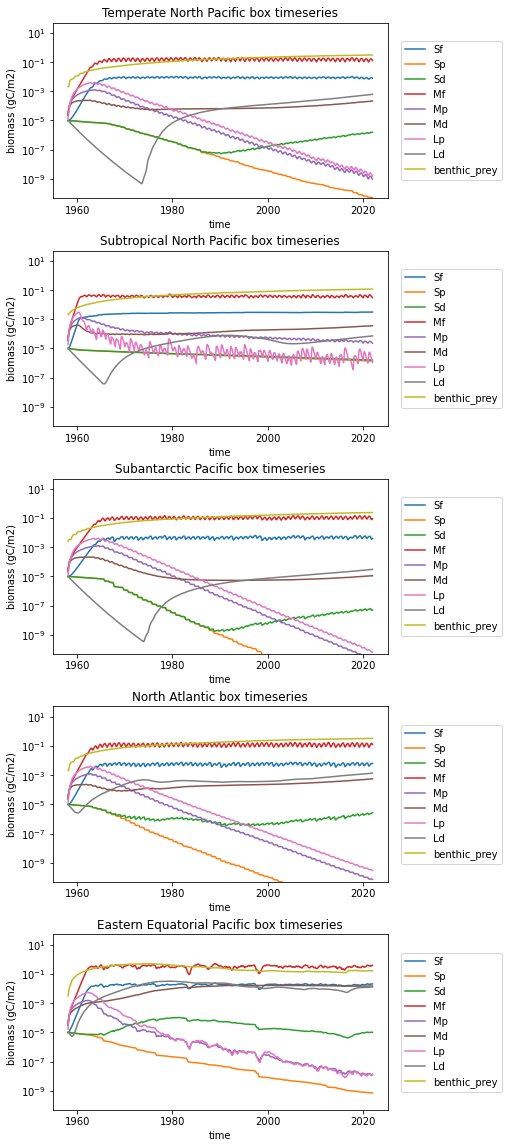

In [32]:
fig = plt.figure(figsize=(6,20))


########################################################################### 
ax = fig.add_subplot(5,1,1)
for group in variables:
    ts_box1[group].plot()
ax.set_ylim([5e-11, 50])
ax.set_yscale("log")
ax.set_ylabel('biomass (gC/m2)')
ax.set_title("Temperate North Pacific box timeseries")
plt.legend(ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)


ax = fig.add_subplot(5,1,2)
for group in variables:
    ts_box2[group].plot()
ax.set_ylim([5e-11, 50])
ax.set_yscale("log")
ax.set_ylabel('biomass (gC/m2)')
ax.set_title("Subtropical North Pacific box timeseries")
plt.legend(ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)

ax = fig.add_subplot(5,1,3)
for group in variables:
    ts_box3[group].plot()
ax.set_ylim([5e-11, 50])
ax.set_yscale("log")
ax.set_ylabel('biomass (gC/m2)')
ax.set_title("Subantarctic Pacific box timeseries")
plt.legend(ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)


ax = fig.add_subplot(5,1,4)
for group in variables:
    ts_box4[group].plot()
ax.set_ylim([5e-11, 50])
ax.set_yscale("log")
ax.set_ylabel('biomass (gC/m2)')
ax.set_title("North Atlantic box timeseries")
plt.legend(ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)


ax = fig.add_subplot(5,1,5)
for group in variables:
    ts_box5[group].plot()
ax.set_ylim([5e-11, 50])
ax.set_yscale("log")
ax.set_ylabel('biomass (gC/m2)')
ax.set_title("Eastern Equatorial Pacific box timeseries")
plt.legend(ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)


fig.subplots_adjust(hspace=0.3)